In [47]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

In [48]:
# parameters cell
meshpath = "/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/"
abg = [50, 15, -90]
variable = 'temp'
input_paths = ["/Users/nkolduno/PYTHON/DATA/output_7_8/",
               '/Users/nkolduno/PYTHON/DATA/output_7_10',
               ]
input_names = ['control', 'opt1']
years = range(1978, 1986)
reference_path = '/Users/nkolduno/PYTHON/DATA/CLIM_on_mesh/core2_meanz/'
reference_name = 'clim'
reference_years = 1948
figsize=(10, 5)
levels = [-1, 1, 41]
maxdepth = 6000
units = r'$^\circ$C'
columns = 2
dpi = 200
fontsize = 12
cmap='seismic'

ofile = None

lon_start = -30
lat_start = -70
lon_end = -30
lat_end = 60
npoints   = 100

xaxis = 'lat' # possible: 'distance, 'lon', 'lat'
transect_name=None
how='mean'

In [49]:
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [50]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2


<GeoAxesSubplot:>

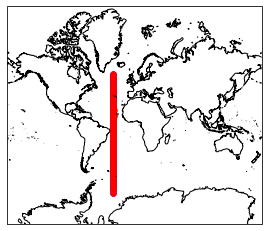

In [51]:
pf.plot_transect_map(lonlat, mesh, view='w')

In [54]:
hofm = OrderedDict()
data_reference = pf.get_data(reference_path, variable, reference_years, mesh, how=how, silent=True, compute=False)
ref_dist, ref_transect_data = pf.get_transect(data_reference, mesh, lonlat)
for exp_path, exp_name  in zip(input_paths, input_names):
    data = pf.get_data(exp_path, variable, years, mesh, how=how, compute=False, silent=True)
    title = exp_name+" - "+reference_name
    hofm[title] = {}
    data_dist, data_transect_data = pf.get_transect(data, mesh, lonlat)
    data_difference= data_transect_data - ref_transect_data
    hofm[title]['data'] = data_difference
    if (data_difference.max() == data_difference.min() == 0):
        hofm[title]['nodiff'] = True
    else:
        hofm[title]['nodiff'] = False
    del data
    print(exp_name)

control
opt1


In [55]:
def data_to_plot(hofm):
    plot_data = []
    plot_names = []
    for key, value in hofm.items():
        if value['nodiff'] is False:
            plot_data.append(value['data'])
            plot_names.append(key)
                
    return plot_data, plot_names

In [56]:
plot_data, plot_names = data_to_plot(hofm)
if not plot_data:
    print('There is no difference between fields')
    identical = True
else:
    identical = False

if len(plot_data) == 1:
    plot_data = plot_data[0]
    plot_names = plot_names[0]

In [57]:
if xaxis=='distance':
    xvals = data_dist
    xlabel = 'km'
elif xaxis=='lon':
    xvals = lonlat[0,:]
    xlabel = r'$^\circ$Lon'
elif xaxis=='lat':
    xvals = lonlat[1,:]
    xlabel = r'$^\circ$Lat'
else:
    raise ValueError(f'{xaxis} is not allowed as value for xaxis. Use `distance`, `lon` or `lat`')

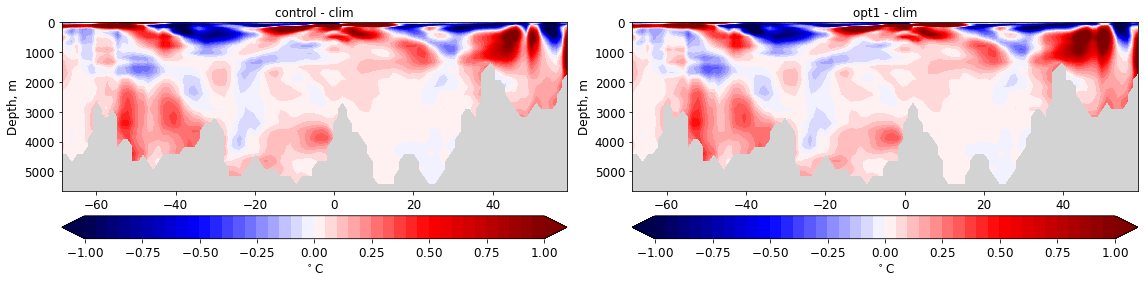

In [58]:
pf.plot_xyz(mesh, plot_data, xvals,
             levels = levels, maxdepth=maxdepth, cmap=cmap, title=plot_names, ncols=columns, fontsize=fontsize, 
            label=units , xlabel=xlabel)
if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')